# Involutional neural networks

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2021/07/25<br>
**Last modified:** 2021/07/25<br>
**Description:** Deep dive into location-specific and channel-agnostic "involution" kernels.

## Introduction

Convolution has been the basis of most modern neural
networks for computer vision. A convolution kernel is
spatial-agnostic and channel-specific. Because of this, it isn't able
to adapt to different visual patterns with respect to
different spatial locations. Along with location-related problems, the
receptive field of convolution creates challenges with regard to capturing
long-range spatial interactions.

To address the above issues, Li et. al. rethink the properties
of convolution in
[Involution: Inverting the Inherence of Convolution for VisualRecognition](https://arxiv.org/abs/2103.06255).
The authors propose the "involution kernel", that is location-specific and
channel-agnostic. Due to the location-specific nature of the operation,
the authors say that self-attention falls under the design paradigm of
involution.

This example describes the involution kernel, compares two image
classification models, one with convolution and the other with
involution, and also tries drawing a parallel with the self-attention
layer.

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import einops

# Set seed for reproducibility.
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Convolution

Convolution remains the mainstay of deep neural networks for computer vision.
To understand Involution, it is necessary to talk about the
convolution operation.

![Imgur](https://i.imgur.com/MSKLsm5.png)

Consider an input tensor **X** with dimensions **H**, **W** and
**C_in**. We take a collection of **C_out** convolution kernels each of
shape **K**, **K**, **C_in**. With the multiply-add operation between
the input tensor and the kernels we obtain an output tensor **Y** with
dimensions **H**, **W**, **C_out**.

In the diagram above `C_out=3`. This makes the output tensor of shape H,
W and 3. One can notice that the convoltuion kernel does not depend on
the spatial position of the input tensor which makes it
**location-agnostic**. On the other hand, each channel in the output
tensor is based on a specific convolution filter which makes is
**channel-specific**.

## Involution

The idea is to have an operation that is both **location-specific**
and **channel-agnostic**. Trying to implement these specific properties poses
a challenge. With a fixed number of involution kernels (for each
spatial position) we will **not** be able to process variable-resolution
input tensors.

To solve this problem, the authors have considered *generating* each
kernel conditioned on specific spatial positions. With this method, we
should be able to process variable-resolution input tensors with ease.
The diagram below provides an intuition on this kernel generation
method.

![Imgur](https://i.imgur.com/jtrGGQg.png)

참고 :  https://cdm98.tistory.com/63?category=757886

- Spatial-agnostic & channel-specific한 기존의 convolution 대신 spatial-specific & channel-agnostic한 involution 제안
- 더욱 넓은 spatial context를 반영하여 long-range interactions를 담을 수 있음
- spatial domain에서 가장 중요한 visual elements에 weights를 줌으로써 prioritize 할 수 있음
- 결국 convolution 보다 spatial attention 능력이 뛰어나고 효율적인 것으로 보임 

In [2]:

class Involution(nn.Module):
    def __init__(self, in_channel, out_channel, group_number, kernel_size, stride, reduction_ratio, padding=(2,2)):
        super().__init__()

        # Initialize the parameters.
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio
        self.padding = padding
        
        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            nn.AvgPool2d(kernel_size=self.stride, stride=self.stride, padding=(0,0))
            if self.stride > 1
            else nn.Identity()
        )
        # Define the kernel generation layer.
        self.kernel_gen = nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel // self.reduction_ratio,
                                                 kernel_size=1),
                                       nn.BatchNorm2d(num_features=self.out_channel // self.reduction_ratio),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=self.out_channel // self.reduction_ratio,
                                                out_channels=self.kernel_size * self.kernel_size * self.group_number,
                                                kernel_size=1))

        self.unfold = nn.Unfold(kernel_size=self.kernel_size, dilation=(1, 1), padding=self.padding, stride=self.stride)

    def forward(self, x):
        # x : (B, C, H, W)
        (batch_size, num_channels, height, width) = x.shape
        
        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride
        
        # Generate the kernel with respect to the input tensor.
        # B, K*K*G, H, W
        kernel_input = self.stride_layer(x) # (B, C, H, W)
        kernel = self.kernel_gen(kernel_input) # (B, K*K*G, H, W)

        # reshape the kerenl
        # B, K*K, 1, G, H, W
        kernel = einops.rearrange(kernel, 'B (K2 G) H W -> B K2 1 G H W', K2=self.kernel_size**2, G=self.group_number)
        
        # Extract input patches.
        # B, K*K*C, (H, W)
        input_patches = self.unfold(x) # torch.Size([256, 75, 1024])

        # Reshape the input patches to align with later operations.
        # B, K*K, C//G, G, H, W
        # einops : equation에서 notation이 left, rigth 모두에 공통으로 있는 것은 정의하지 않아도 됨, 다만 한쪽만 있는 것은 정의 필요
        input_patches = einops.rearrange(input_patches, 'B (K2 C_G G) (H W) -> B K2 C_G G H W',
                                         K2=self.kernel_size**2, G=self.group_number, H=height, W=width)

        # Compute the multiply-add operation of kernels and patches.
        # B, K*K, C//G, G, H, W
        output = torch.multiply(kernel, input_patches)
        
        # B, C//G, G, H, W
        output = torch.sum(output, dim=1)

        # Reshape the output kernel.
        # B, C, H, W
        output = output.view(batch_size, num_channels, height, width)
        
        # Return the output tensor and the kernel.
        return output, kernel


## Testing the Involution layer

In [3]:
# Define the input tensor.
input_tensor = torch.randn((256, 3, 32, 32))

# Compute involution with stride 1.
output_tensor, _ = Involution(
    in_channel=3, out_channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    in_channel=3, out_channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    in_channel=3, out_channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2)(input_tensor)
print(
    "with output channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)

with stride 1 ouput shape: torch.Size([256, 3, 32, 32])
with stride 2 ouput shape: torch.Size([256, 3, 16, 16])
with output channel 16 and reduction ratio 2 ouput shape: torch.Size([256, 3, 32, 32])


## Image Classification

In this section, we will build an image-classifier model. There will
be two models one with convolutions and the other with involutions.

The image-classification model is heavily inspired by this
[Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)
tutorial from Google.

## Get the CIFAR10 Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
iter(trainloader).next()[0].shape

torch.Size([256, 3, 32, 32])

In [6]:
iter(trainloader).next()[1].shape

torch.Size([256])

In [7]:
len(trainloader)

196

## Visualise the data

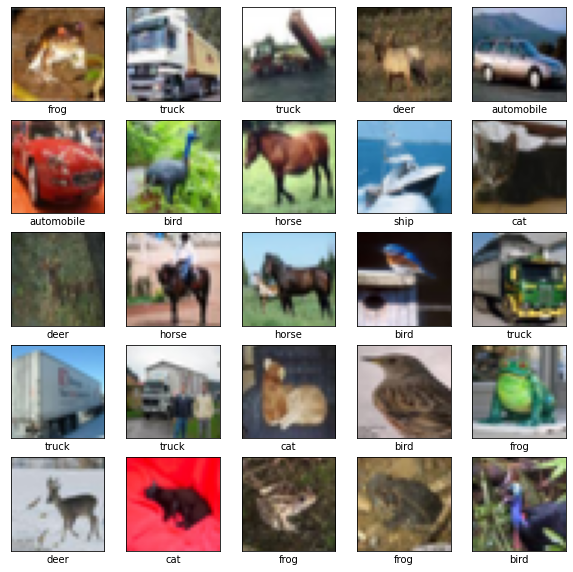

In [8]:
import numpy as np

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    img = trainset[i][0] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.xlabel(class_names[trainset[i][1]])
plt.show()

## Convolutional Neural Network

In [9]:
# Build the conv model.
print("building the convolution model...")

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, (3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(64, 64, (3,3), padding=(1,1))
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*64, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out = self.conv3(out)
        out = F.relu(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out
    

building the convolution model...


In [10]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.optim as optim
from tqdm.notebook import trange

# Compile the mode with the necessary loss function and optimizer.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print ('Current device : ', device)

conv_model = ConvNet().to(device)


epochs=20
learning_rate=0.0005
total_step = len(trainloader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)

# Train the model.
print("conv model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(epochs):
    running_loss = 0
    conv_model.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = conv_model(inputs)  # torch.Size([256, 10])
        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(testloader):
        conv_model.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = conv_model(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

conv_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}


Current device :  cuda
conv model training...


Epoch [1/20], Step [49/196], Loss: 1.8684
Epoch [1/20], Step [99/196], Loss: 1.5505
Epoch [1/20], Step [149/196], Loss: 1.4351
=> Train Accuracy : 38.222%  |  Valid Accuracy : 46.92%
Epoch [2/20], Step [49/196], Loss: 1.3676
Epoch [2/20], Step [99/196], Loss: 1.3344
Epoch [2/20], Step [149/196], Loss: 1.2030
=> Train Accuracy : 50.722%  |  Valid Accuracy : 53.18%
Epoch [3/20], Step [49/196], Loss: 1.3105
Epoch [3/20], Step [99/196], Loss: 1.1925
Epoch [3/20], Step [149/196], Loss: 1.0971
=> Train Accuracy : 55.818%  |  Valid Accuracy : 57.21%
Epoch [4/20], Step [49/196], Loss: 1.1216
Epoch [4/20], Step [99/196], Loss: 1.1817
Epoch [4/20], Step [149/196], Loss: 1.0974
=> Train Accuracy : 59.874%  |  Valid Accuracy : 59.32%
Epoch [5/20], Step [49/196], Loss: 1.1131
Epoch [5/20], Step [99/196], Loss: 1.0225
Epoch [5/20], Step [149/196], Loss: 1.0264
=> Train Accuracy : 62.82%  |  Valid Accuracy : 63.91%
Epoch [6/20], Step [49/196], Loss: 1.1382
Epoch [6/20], Step [99/196], Loss: 1.0507
Ep

## Involutional Neural Network

In [11]:
# Build the involution model.
print("building the involution model...")


class InvolutionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inv1 = Involution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.inv2 = Involution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.inv3 = Involution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(192, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        out, _ = self.inv1(x)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out, _ = self.inv2(out)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out, _ = self.inv3(out)
        out = F.relu(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out
    

building the involution model...


In [12]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.optim as optim
from tqdm.notebook import trange

# Compile the mode with the necessary loss function and optimizer.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print ('Current device : ', device)

inv_model = InvolutionNet().to(device)


epochs=20
learning_rate=0.0005
total_step = len(trainloader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inv_model.parameters(), lr=learning_rate)

# Train the model.
print("involution model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(epochs):
    running_loss = 0
    inv_model.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = inv_model(inputs)  # torch.Size([256, 10])
        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(testloader):
        inv_model.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = inv_model(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

inv_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}

Current device :  cuda
involution model training...


Epoch [1/20], Step [49/196], Loss: 2.2593
Epoch [1/20], Step [99/196], Loss: 2.2775
Epoch [1/20], Step [149/196], Loss: 2.2353
=> Train Accuracy : 15.8%  |  Valid Accuracy : 21.03%
Epoch [2/20], Step [49/196], Loss: 2.1588
Epoch [2/20], Step [99/196], Loss: 2.1630
Epoch [2/20], Step [149/196], Loss: 2.0654
=> Train Accuracy : 24.28%  |  Valid Accuracy : 27.03%
Epoch [3/20], Step [49/196], Loss: 2.0135
Epoch [3/20], Step [99/196], Loss: 1.9838
Epoch [3/20], Step [149/196], Loss: 2.0246
=> Train Accuracy : 28.198%  |  Valid Accuracy : 29.67%
Epoch [4/20], Step [49/196], Loss: 1.8791
Epoch [4/20], Step [99/196], Loss: 1.9976
Epoch [4/20], Step [149/196], Loss: 1.9164
=> Train Accuracy : 30.184%  |  Valid Accuracy : 31.06%
Epoch [5/20], Step [49/196], Loss: 1.8824
Epoch [5/20], Step [99/196], Loss: 1.8772
Epoch [5/20], Step [149/196], Loss: 1.9088
=> Train Accuracy : 31.994%  |  Valid Accuracy : 32.04%
Epoch [6/20], Step [49/196], Loss: 1.8301
Epoch [6/20], Step [99/196], Loss: 1.8257
Epoc

## Comparisons

In this section, we will be looking at both the models and compare a
few pointers.

### Parameters

One can see that with a similar architecture the parameters in a CNN
is much larger than that of an INN (Involutional Neural Network).

In [13]:
from torchsummary import summary

summary(conv_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
            Linear-6                   [-1, 64]         262,208
            Linear-7                   [-1, 10]             650
Total params: 319,178
Trainable params: 319,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.50
Params size (MB): 1.22
Estimated Total Size (MB): 1.73
----------------------------------------------------------------


In [14]:

class SumInvolution(nn.Module):
    def __init__(self, in_channel, out_channel, group_number, kernel_size, stride, reduction_ratio, padding=(2,2)):
        super().__init__()

        # Initialize the parameters.
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio
        self.padding = padding
        
        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            nn.AvgPool2d(kernel_size=self.stride, stride=self.stride, padding=(0,0))
            if self.stride > 1
            else nn.Identity()
        )
        # Define the kernel generation layer.
        self.kernel_gen = nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel // self.reduction_ratio,
                                                 kernel_size=1),
                                       nn.BatchNorm2d(num_features=self.out_channel // self.reduction_ratio),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=self.out_channel // self.reduction_ratio,
                                                out_channels=self.kernel_size * self.kernel_size * self.group_number,
                                                kernel_size=1))

        self.unfold = nn.Unfold(kernel_size=self.kernel_size, dilation=(1, 1), padding=self.padding, stride=self.stride)

    def forward(self, x):
        # x : (B, C, H, W)
        (batch_size, num_channels, height, width) = x.shape
        
        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride
        
        # Generate the kernel with respect to the input tensor.
        # B, K*K*G, H, W
        kernel_input = self.stride_layer(x) # (B, C, H, W)
        kernel = self.kernel_gen(kernel_input) # (B, K*K*G, H, W)

        # reshape the kerenl
        # B, K*K, 1, G, H, W
        kernel = einops.rearrange(kernel, 'B (K2 G) H W -> B K2 1 G H W', K2=self.kernel_size**2, G=self.group_number)
        
        # Extract input patches.
        # B, K*K*C, (H, W)
        input_patches = self.unfold(x) # torch.Size([256, 75, 1024])

        # Reshape the input patches to align with later operations.
        # B, K*K, C//G, G, H, W
        # einops : equation에서 notation이 left, rigth 모두에 공통으로 있는 것은 정의하지 않아도 됨, 다만 한쪽만 있는 것은 정의 필요
        input_patches = einops.rearrange(input_patches, 'B (K2 C_G G) (H W) -> B K2 C_G G H W',
                                         K2=self.kernel_size**2, G=self.group_number, H=height, W=width)

        # Compute the multiply-add operation of kernels and patches.
        # B, K*K, C//G, G, H, W
        output = torch.multiply(kernel, input_patches)
        
        # B, C//G, G, H, W
        output = torch.sum(output, dim=1)

        # Reshape the output kernel.
        # B, C, H, W
        output = output.view(batch_size, num_channels, height, width)
        
        # Return the output tensor and the kernel.
        return output

class SumInvolutionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inv1 = SumInvolution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.inv2 = SumInvolution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.inv3 = SumInvolution(in_channel=3, out_channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, padding=(1,1))
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(192, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = self.inv1(x)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out = self.inv2(out)
        out = F.relu(out)
        out = self.maxpool(out)
        
        out = self.inv3(out)
        out = F.relu(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out
    
inv_model_sum = SumInvolutionNet().to(device)


In [15]:
summary(inv_model_sum, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1            [-1, 3, 32, 32]               0
            Conv2d-2            [-1, 1, 32, 32]               4
       BatchNorm2d-3            [-1, 1, 32, 32]               2
              ReLU-4            [-1, 1, 32, 32]               0
            Conv2d-5            [-1, 9, 32, 32]              18
            Unfold-6             [-1, 27, 1024]               0
     SumInvolution-7            [-1, 3, 32, 32]               0
         MaxPool2d-8            [-1, 3, 16, 16]               0
          Identity-9            [-1, 3, 16, 16]               0
           Conv2d-10            [-1, 1, 16, 16]               4
      BatchNorm2d-11            [-1, 1, 16, 16]               2
             ReLU-12            [-1, 1, 16, 16]               0
           Conv2d-13            [-1, 9, 16, 16]              18
           Unfold-14              [-1, 

### Loss and Accuracy Plots

Here, the loss and the accuracy plots demonstrate that INNs are slow
learners (with lower parameters).

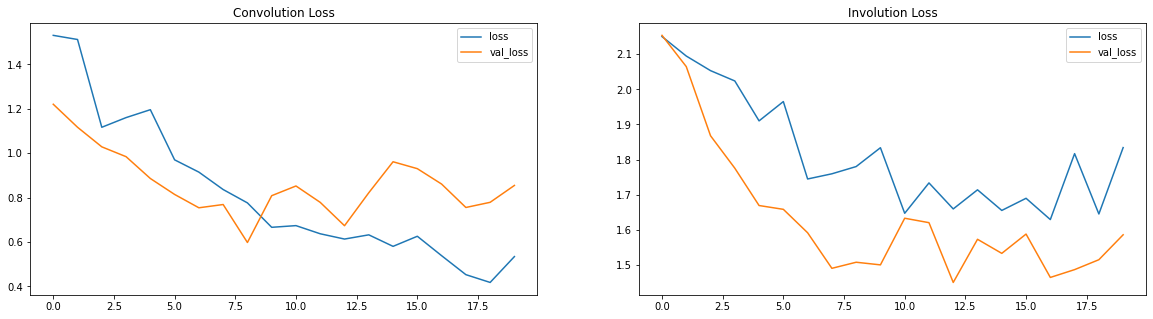

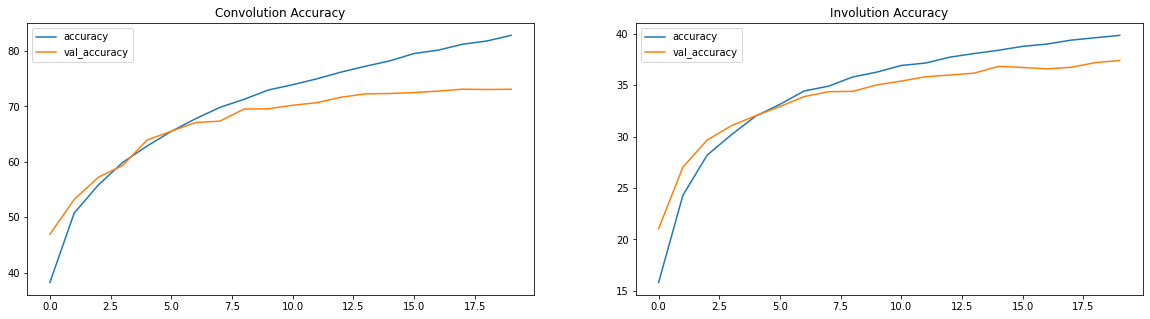

In [16]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_history["train_loss"], label="loss")
plt.plot(conv_history["valid_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inv_history["train_loss"], label="loss")
plt.plot(inv_history["valid_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_history["train_acc"], label="accuracy")
plt.plot(conv_history["valid_acc"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inv_history["train_acc"], label="accuracy")
plt.plot(inv_history["valid_acc"], label="val_accuracy")
plt.legend()

plt.show()

## Visualizing Involution Kernels

To visualize the kernels, we take the sum of **K×K** values from each
involution kernel. **All the representatives at different spatial
locations frame the corresponding heat map.**

The authors mention:

"Our proposed involution is reminiscent of self-attention and
essentially could become a generalized version of it."

With the visualization of the kernel we can indeed obtain an attention
map of the image. The learned involution kernels provides attention to
individual spatial positions of the input tensor. The
**location-specific** property makes involution a generic space of models
in which self-attention belongs.

In [28]:
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

In [29]:
import copy

inv_model_feat = copy.deepcopy(inv_model).to(device)

In [30]:
inv_model_feat.inv1.register_forward_hook(get_features('inv1'))
inv_model_feat.inv2.register_forward_hook(get_features('inv2'))
inv_model_feat.inv3.register_forward_hook(get_features('inv3'))

In [31]:
test_images = []
for i in range(10):
    test_images.append(testloader.dataset[i][0])

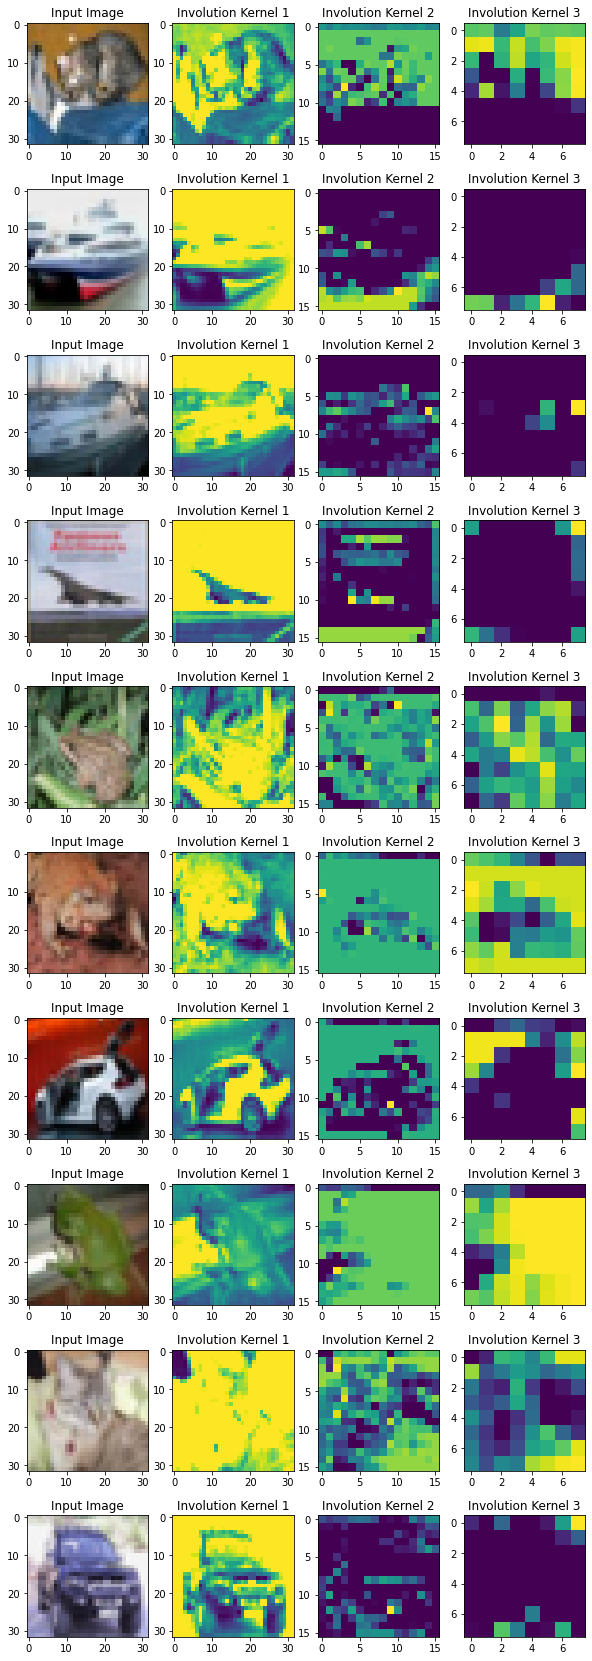

In [33]:
layer_names = ["inv1", "inv2", "inv3"]
outputs = [inv_model_feat.inv1.register_forward_hook(get_features(name)) for name in layer_names]

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    
    test_image = test_image.unsqueeze(0).to(device)
    outputs = inv_model_feat(test_image)
    
    inv1_kernel = features['inv1'][1]
    inv2_kernel = features['inv2'][1]
    inv3_kernel = features['inv3'][1]

    inv1_kernel = torch.sum(inv1_kernel, dim=[1, 2, 3])
    inv2_kernel = torch.sum(inv2_kernel, dim=[1, 2, 3])
    inv3_kernel = torch.sum(inv3_kernel, dim=[1, 2, 3])
    test_image = (test_image / 2 + 0.5).cpu().numpy()

    ax[0].imshow(np.transpose(test_image.squeeze(), (1,2,0)))
    ax[0].set_title("Input Image")

    ax[1].imshow(inv1_kernel[0, ..., None].detach().cpu().numpy())
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(inv2_kernel[0, ..., None].detach().cpu().numpy())
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(inv3_kernel[0, ..., None].detach().cpu().numpy())
    ax[3].set_title("Involution Kernel 3")

In [34]:
features['inv1'][0].shape

torch.Size([1, 3, 32, 32])

In [35]:
features['inv1'][1].shape

torch.Size([1, 9, 1, 1, 32, 32])

## Conclusions

In this example, the main focus was to build an `Involution` layer which
can be easily reused. While our comparisons were based on a specific
task, feel free to use the layer for different tasks and report your
results.

According to me, the key take-away of involution is its
relationship with self-attention. The intuition behind location-specific
and channel-spefic processing makes sense in a lot of tasks.

Moving forward one can:

- Look at [Yannick's video](https://youtu.be/pH2jZun8MoY) on
    involution for a better understanding.
- Experiment with the various hyperparameters of the involution layer.
- Build different models with the involution layer.
- Try building a different kernel generation method altogether.